In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

# Overfitting vs underfitting

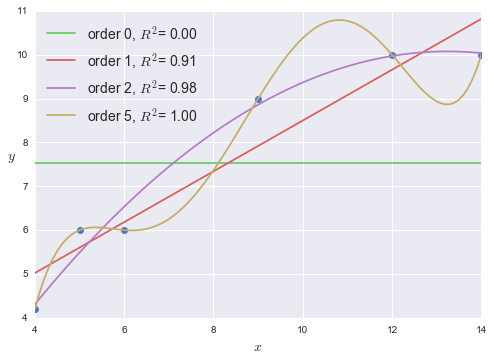

In [2]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label='order {}, $R^2$= {:.2f}'.format(i, r2))

plt.legend(loc=2, fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14, rotation=0)
plt.savefig('B04958_06_01.png', dpi=300, figsize=[5.5, 5.5])
#plt.plot([10, 7], [9, 7], 's')
#plt.savefig('B04958_06_02.png', dpi=300, figsize=[5.5, 5.5])

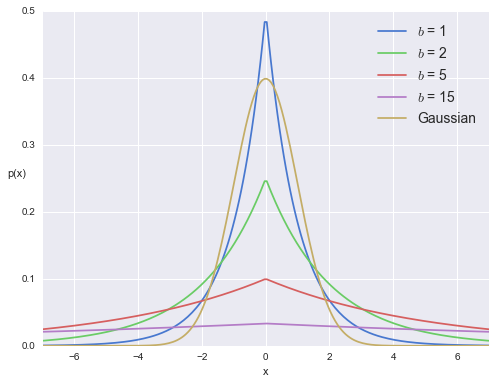

In [3]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 300)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label='$b$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.ylabel('p(x)', rotation=0)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);
plt.savefig('B04958_06_03.png', dpi=300, figsize=[5.5, 5.5])

In [4]:
x_1 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_1 = np.array([  8.04,   6.95,   7.58,   8.81,   8.33,   9.96,   7.24,   4.26,
        10.84,   4.82,   5.68])

In [5]:
np.random.seed(1)
real_alpha = 4.25
real_beta = [8.7, -1.2]
data_size = 20
noise = np.random.normal(0, 2, size=data_size)
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

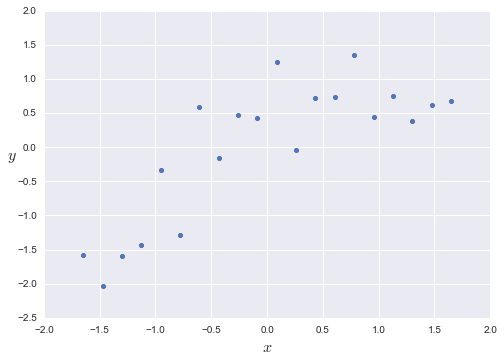

In [6]:
order = 2#5
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_06_04.png', dpi=300, figsize=[5.5, 5.5])

In [7]:
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta * x_1s[0]
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_l = pm.sample(2100)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 2100/2100 [00:02<00:00, 975.32it/s]


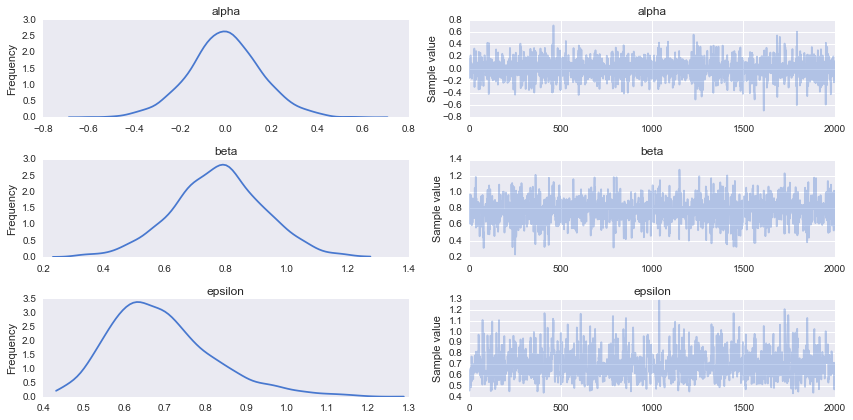

In [8]:
chain_l = trace_l[100:]
pm.traceplot(chain_l);

In [9]:
pm.df_summary(chain_l)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.003331,0.160514,0.003343,-0.341683,0.302035
beta,0.775680,0.150233,0.004497,0.481617,1.069817
epsilon,0.691546,0.128800,0.004260,0.448888,0.947141


In [10]:
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=x_1s.shape[0])  
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, x_1s)
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_p = pm.sample(2100)

100%|██████████| 2100/2100 [00:03<00:00, 612.46it/s]


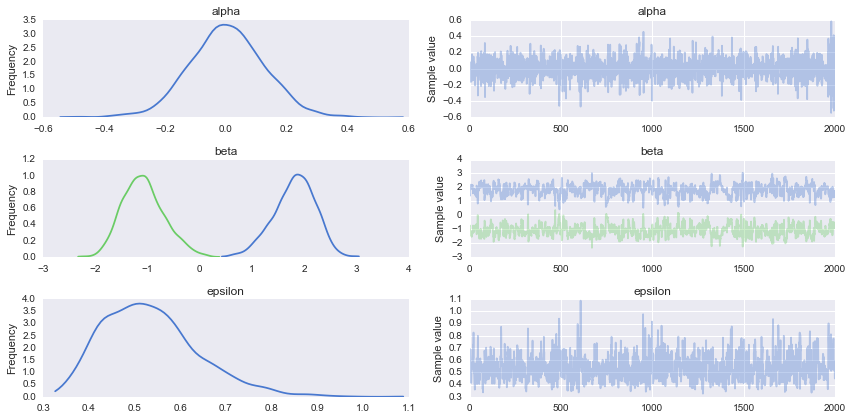

In [11]:
chain_p = trace_p[100:]
pm.traceplot(chain_p);

In [12]:
pm.df_summary(chain_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.003864,0.124936,0.002284,-0.234548,0.237907
beta__0,1.814338,0.398737,0.021912,1.017371,2.533085
beta__1,-1.079318,0.399691,0.021948,-1.819323,-0.274780
epsilon,0.535256,0.104879,0.003976,0.351361,0.736229


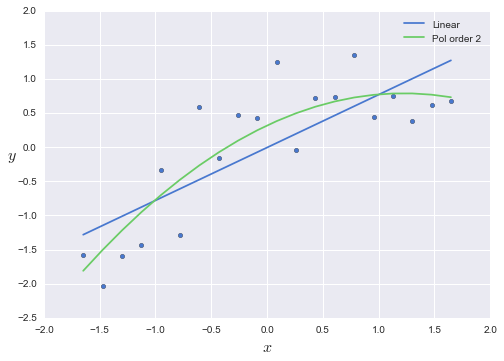

In [13]:
alpha_l_post = chain_l['alpha'].mean()
betas_l_post = chain_l['beta'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_l_post = alpha_l_post + betas_l_post * x_1s[0]

plt.plot(x_1s[0][idx], y_l_post[idx], label='Linear')


alpha_p_post = chain_p['alpha'].mean()
betas_p_post = chain_p['beta'].mean(axis=0)
y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], label='Pol order {}'.format(order))

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0);
plt.legend()
plt.savefig('B04958_06_05.png', dpi=300, figsize=[5.5, 5.5])

# Information criteria

In [14]:
dic_l = pm.dic(trace=trace_l, model=model_l)
dic_l

57.400618388961888

In [15]:
dic_p = pm.dic(trace=trace_p, model=model_p)
dic_p

54.081098137239678

In [16]:
waic_l = pm.waic(trace=trace_l, model=model_l)
waic_l

(42.944262464359909, 4.1064164750276486)

In [17]:
waic_p = pm.waic(trace=trace_p, model=model_p)
waic_p

(32.809701279623269, 4.430686673627112)

In [18]:
loo_l = pm.loo(trace=trace_l, model=model_l)
loo_l

/home/osvaldo/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:192: UserWarning: Estimated shape parameter of Pareto distribution
        is for one or more samples is greater than 0.5. This may indicate
        that the variance of the Pareto smoothed importance sampling estimate
        is very large.
  is very large.""")


(38.456980606877266, 3.3622290516518194)

In [19]:
loo_p = pm.loo(trace=trace_p, model=model_p)
loo_p

/home/osvaldo/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:192: UserWarning: Estimated shape parameter of Pareto distribution
        is for one or more samples is greater than 0.5. This may indicate
        that the variance of the Pareto smoothed importance sampling estimate
        is very large.
  is very large.""")


(27.738717876566785, 3.5610811003793139)

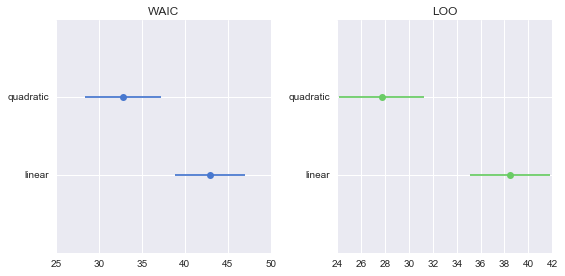

In [20]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
for idx, ic in enumerate((waic_l, waic_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='bo')
plt.title('WAIC')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.subplot(122)
for idx, ic in enumerate((loo_l, loo_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='go')
plt.title('LOO')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.tight_layout()

plt.savefig('B04958_06_06.png', dpi=300, figsize=[5.5, 5.5])

## Posterior predictive checks

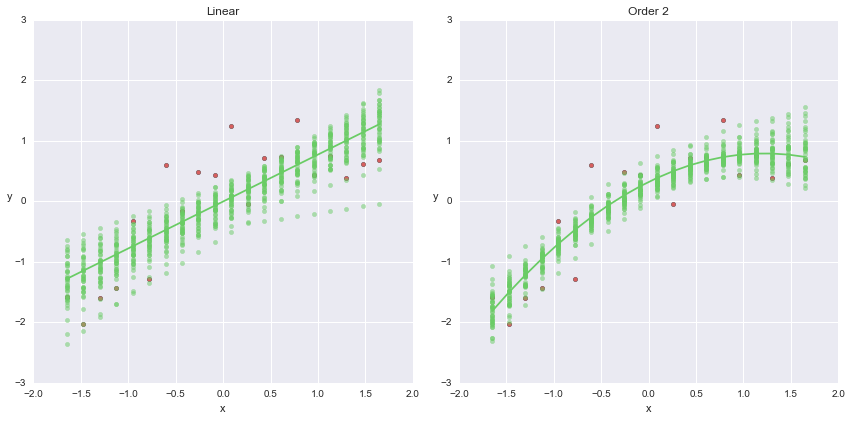

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='r');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Linear')


for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_l['alpha'][i] + chain_l['beta'][i]*x_1s[0], c='g',
                edgecolors='g', alpha=0.5);
plt.plot(x_1s[0], chain_l['alpha'].mean() + chain_l['beta'].mean()*x_1s[0], c='g', alpha=1)

    
plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='r');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Order {}'.format(order))
for i in range(0, len(chain_p['alpha']), 50):
    plt.scatter(x_1s[0], chain_p['alpha'][i] + np.dot(chain_p['beta'][i], x_1s), c='g',
                edgecolors='g', alpha=0.5)
idx = np.argsort(x_1)
plt.plot(x_1s[0][idx], alpha_p_post + np.dot(betas_p_post, x_1s)[idx], c='g', alpha=1);

plt.tight_layout()
plt.savefig('B04958_06_07.png', dpi=300, figsize=[5.5, 5.5])

# Bayes factors

In [2]:
coins = 30 # 300
heads = 9 # 90
y = np.repeat([0, 1], [coins-heads, heads])

In [3]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', theta, observed=y)
     
    trace_BF = pm.sample(5000)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 5000/5000 [00:05<00:00, 990.61it/s] 


0.960666666667 0.0393333333333 24.4237288136


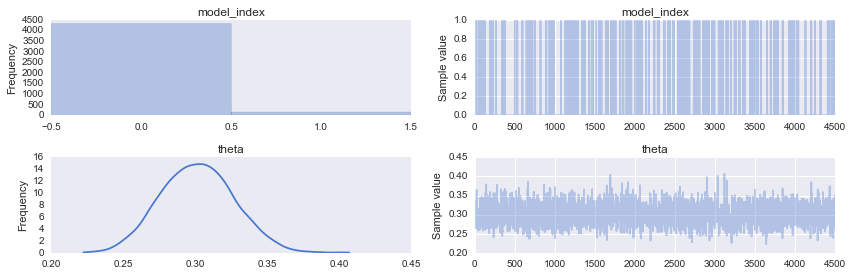

In [4]:
chain_BF = trace_BF[500:]
pm.traceplot(chain_BF)
pM1 = chain_BF['model_index'].mean()
pM0 = 1 - pM1
print(pM0, pM1, (pM0/pM1)*(p[1]/p[0]))
plt.savefig('B04958_06_09.png', dpi=300, figsize=[5.5, 5.5])

In [5]:
with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y)
    
    trace_BF_0 = pm.sample(5000)  

100%|██████████| 5000/5000 [00:02<00:00, 1709.83it/s]


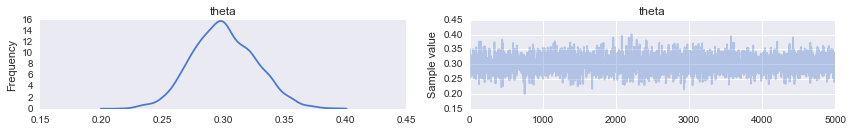

In [6]:
chain_BF_0 = trace_BF_0[500:]
pm.traceplot(trace_BF_0)
plt.savefig('B04958_06_10.png', dpi=300, figsize=[5.5, 5.5])

In [7]:
with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y)
    
    trace_BF_1 = pm.sample(5000)

100%|██████████| 5000/5000 [00:02<00:00, 2098.74it/s]


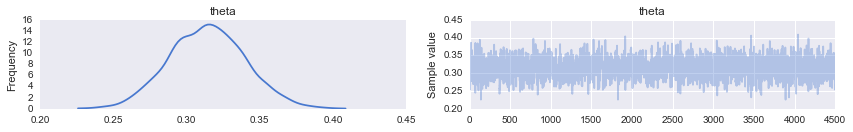

In [8]:
chain_BF_1 = trace_BF_1[500:]
pm.traceplot(chain_BF_1)
plt.savefig('B04958_06_11.png', dpi=300, figsize=[5.5, 5.5])

In [29]:
waic_0 = pm.waic(chain_BF_0, model_BF_0)
waic_0

(38.142143128303665, 4.2546178793313958)

In [30]:
waic_1 = pm.waic(chain_BF_1, model_BF_1)
waic_1

(39.373190678875915, 2.0225338617453903)

In [31]:
loo_0 = pm.loo(chain_BF_0, model_BF_0)
loo_0

/home/osvaldo/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:192: UserWarning: Estimated shape parameter of Pareto distribution
        is for one or more samples is greater than 0.5. This may indicate
        that the variance of the Pareto smoothed importance sampling estimate
        is very large.
  is very large.""")


(36.64447653192989, 4.0235302895769234)

In [32]:
loo_1 = pm.loo(chain_BF_1, model_BF_1)
loo_1

/home/osvaldo/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:192: UserWarning: Estimated shape parameter of Pareto distribution
        is for one or more samples is greater than 0.5. This may indicate
        that the variance of the Pareto smoothed importance sampling estimate
        is very large.
  is very large.""")


(38.051221773420316, 1.9194817481688398)

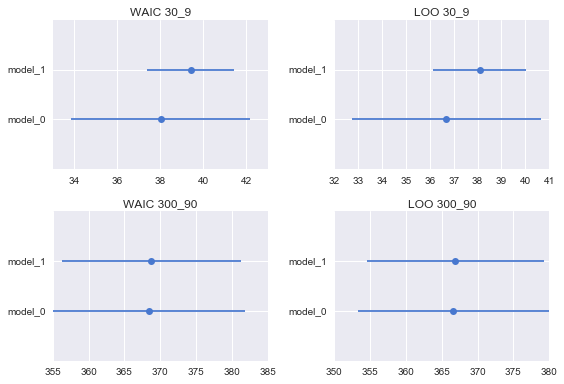

In [34]:
est = [((38.02, 4.17), (39.41, 2.04)), ((36.69, 3.96), (38.09, 1.94)),
       ((368.41, 13.40), (368.76, 12.48)) , ((366.61, 13.31), (366.87, 12.34))]

title = ['WAIC 30_9', 'LOO 30_9', 'WAIC 300_90', 'LOO 300_90']

for i in range(4):
    plt.subplot(2,2,i+1)
    for idx, ic in enumerate(est[i]):
        plt.errorbar(ic[0], idx, xerr=ic[1], fmt='bo')
    plt.title(title[i])
    plt.yticks([0, 1], ['model_0', 'model_1'])
    plt.ylim(-1, 2)

plt.tight_layout()

plt.savefig('B04958_06_12.png', dpi=300, figsize=[5.5, 5.5])

In [36]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.5.2
IPython 5.0.0
PyMC3 3.0.rc2
NumPy 1.11.1
SciPy 0.18.1
Matplotlib 1.5.3
Seaborn 0.7.1
